<a href="https://colab.research.google.com/github/MHadavand/Lessons/blob/master/ML/ANN/TimeSeries/TimeSeries1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
from matplotlib import pyplot as plt

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.layers import LSTM, SimpleRNN, Dropout, GRU, Conv1D, MaxPool1D
from tensorflow.keras.callbacks import LambdaCallback, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam, Nadam


%load_ext autoreload
%autoreload 2

In [ ]:
class TimeSeriesData():


    def __init__(self):
        self.file_dict = {'FluDataSet': [r'../../Data/flusearches.csv', 'flu'], 'AirlineSales': [r'../../Data/international-airline-passengers.csv', 'passengers'], 'SinData': [r'Data/sin.csv','sin'], 'FemaleBirth':[r'../../Data/daily-total-female-births.csv','Births']}
        print('List of data sources:')
        for item in self.file_dict.keys():
            print('\t{}'.format(item))

    def load_data(self, source_name, normalize=True):
        import pandas as pd
        from matplotlib import pyplot as plt
        """read a CSV into a dataframe"""

        self.source_name = source_name

        if self.source_name in self.file_dict.keys():
            df = pd.read_csv(self.file_dict[self.source_name][0])
            self.data = df[self.file_dict[self.source_name][1]].astype('float32').values
        else:
            raise ValueError('The source name was not found')
            self.__init__()
        if normalize:
            max_val = max(self.data)
            min_val = min(self.data)
            self.data = (self.data-min_val)/(max_val-min_val)
        fig, ax = plt.subplots(1,1, figsize = (8,5))
        ax.plot(self.data)
        ax.grid()
        ax.set_title('{}'.format(self.source_name))



    def create_sequential_data(self, look_back, train_portion=0.7):
        """convert an array of values into a data matrix
            A data sequence of selected length(i.e look_back) will be set as the training data
            and the next number is the label
        """
        split = int(len(self.data) * 0.70)
        train = self.data[:split]
        # test = data[split-look_back-2:]
        test = self.data[split-look_back:]

        dataX_train, dataY_train = [], []

        # for i in range(len(dataset)-look_back-1):
        for i in range(len(train)-look_back):
            a = train[i:(i+look_back)]
            dataX_train.append(a)
            dataY_train.append(train[i + look_back])

        dataX_test, dataY_test = [], []
        # for i in range(len(dataset)-look_back-1):
        for i in range(len(test)-look_back):
            a = test[i:(i+look_back)]
            dataX_test.append(a)
            dataY_test.append(test[i + look_back])

        return np.array(dataX_train), np.array(dataY_train), np.array(dataX_test), np.array(dataY_test)


# Load data

In [ ]:
time_data = TimeSeriesData()

List of data sources:
	FluDataSet
	AirlineSales
	SinData
	FemaleBirth


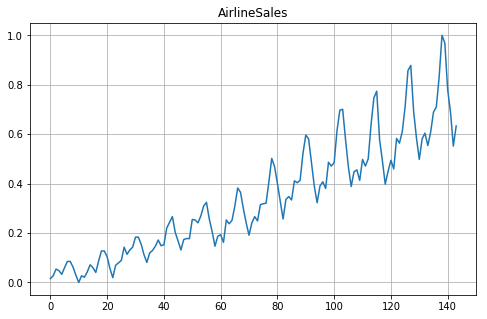

In [ ]:
time_data.load_data('AirlineSales', normalize=True)

# Using simple linear regression

Relying on classic linear regression based on covariance between the response and missing variables.

In [ ]:
X, y = range(len(time_data.data)), time_data.data

# Train and test data sets
split = int(len(X) * 0.70)

X_train,X_test = X[:split], X[split:]
y_train,y_test = y[:split], y[split:]

In [ ]:
slope_math = np.cov(X_train,y_train)[0][1]/np.cov(X_train,y_train)[0][0] # Covariance(X,y)/Variance(X)
intercept_math = np.mean(y_train)-slope_math*np.mean(X_train) # mean(y) - slope * mean(X)

In [ ]:
y_predicted = X * slope_math + intercept_math

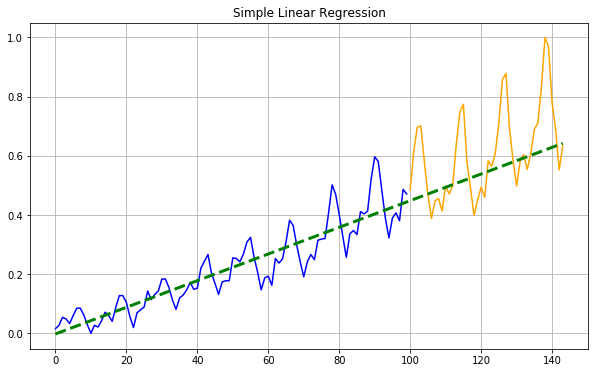

In [ ]:
fig, ax = plt.subplots(1,1, figsize= (10,6))
ax.plot(X_train,y_train,'b')
ax.plot(X_test,y_test,'orange')
ax.plot(X,y_predicted,'g', lw=3,ls='--')
ax.set_title('Simple Linear Regression')
ax.grid()

# Using Neural Network

Neural networks are robust to noise in input data and can be trained even in presence of missing values. Also, there is no strong assumption about the linearity of the mapping function between the input and output. Thus neural networks can learn/approximate linear and non-linear relationships 

"... One important contribution of neural networks namely their ability to approximate arbitrary non-linear functions. This property is of high value in time series processing and promises more powerful applications ..."

__Georg Dorffner, Neural Network for Time Series Processing, 1996


## Helper functions and classes

In [18]:
class Config():
    def __init__(self, batch_size, look_back, n_epochs, train_portion, min_delta, stop_patience, lr_patience=None, rnn_nodes = None, repeated_predictions=False, monitor ='loss'):    
        self.repeated_predictions = repeated_predictions
        self.batch_size = batch_size
        self.rnn_nodes = rnn_nodes
        self.look_back = look_back
        self.n_epochs = n_epochs
        self.train_portion = train_portion
        
        # Early stop call back for keras
        self.early_stop_clbk = tf.keras.callbacks.EarlyStopping(monitor='loss', 
                                                                min_delta=min_delta, 
                                                                patience=stop_patience,
                                                                verbose=0, 
                                                                mode='auto',
                                                                restore_best_weights=True)
        if lr_patience is not None:
            # Adaptive learning rate call back for keras
            self.lr_plan = ReduceLROnPlateau(monitor='val_loss',
                                             factor=0.1,patience=lr_patience,
                                             verbose=0,
                                             mode='auto',
                                             min_delta=min_delta)
            
def plot_model_results(model, history):
    fig, main_ax = plt.subplots(1,2, figsize= (16,5))

    ax = main_ax[0]
    ax.plot(history.history['loss'], label='Loss')
    ax.plot(history.history['val_loss'], label='Validation Loss')
    ax.grid()
    ax.legend()

    ax = main_ax[1]
    preds_test = model.predict(testX)
    preds_train = model.predict(trainX)
    ax.plot(trainY, label='Training Value')
    ax.plot(preds_train, label='Training Prediction')
    ax.plot(np.append(np.empty_like(trainY) * np.nan, testY), label='Test Value')
    ax.plot(np.append(np.empty_like(trainY) * np.nan, preds_test), label = 'Test Prediction')
    ax.legend()
    ax.grid()

## Using Multi Layer Perceptron (MLP) Netwroks

Feed-forward networks are widely used for time series prediction.

In [ ]:
config = Config(batch_size=50, look_back=15, n_epochs = 2000, train_portion = 0.7, min_delta=0.001, stop_patience=200)

### Sliding Window Transformation

Using sliding window transformation to transform time series data into supervised learning format i.e. input and output.

[1,2,3,4,5,6,7,8,...]

  &ensp;&ensp;X&ensp;&ensp;&ensp;&ensp;&ensp;&ensp;&ensp;Y
  
[1,2,3]&ensp;&ensp;&ensp;&ensp;[4]

[2,3,4]&ensp;&ensp;&ensp;&ensp;[5]

[3,4,5]&ensp;&ensp;&ensp;&ensp;[6]

...

The number of look back defines how many data records in the past will be included in the training data set to inform the next data record as the label

In [ ]:
trainX, trainY, testX, testY = time_data.create_sequential_data(look_back=config.look_back,
                                                                train_portion=config.train_portion)

In [ ]:
model = Sequential(name='MLPSequential')

model.add(Dense(32, input_shape=(config.look_back,), activation="relu",name='Dense1')) 

model.add(Dropout(0.1))

model.add(Dense(1, activation="linear", name='Output'))

model.compile(loss='mae', optimizer=Adam(0.001))

model.summary()

Model: "MLPSequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Dense1 (Dense)               (None, 32)                512       
_________________________________________________________________
dropout (Dropout)            (None, 32)                0         
_________________________________________________________________
Output (Dense)               (None, 1)                 33        
Total params: 545
Trainable params: 545
Non-trainable params: 0
_________________________________________________________________


In [ ]:
history = model.fit(trainX, trainY, epochs=config.n_epochs, 
                    batch_size=config.batch_size, 
                    validation_data=(testX, testY), 
                    callbacks=[config.early_stop_clbk])

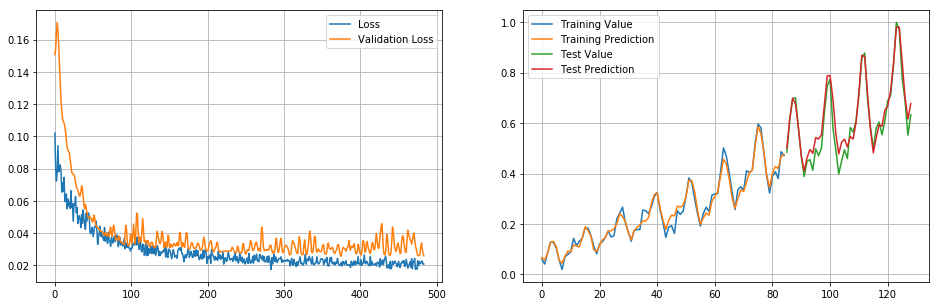

In [ ]:
plot_model_results(model, history)

## Using CNN

using convolutional neural networks

In [ ]:
# Central configuration
config = Config(batch_size=50, look_back=20, n_epochs = 2000, train_portion = 0.7, min_delta=0.001, stop_patience=200)

In [ ]:
trainX, trainY, testX, testY = time_data.create_sequential_data(look_back=config.look_back,
                                                                train_portion=config.train_portion)

# Add channel dimension
trainX = trainX[:, :, np.newaxis] # n_observations, n_sequence, n_features
testX = testX[:, :, np.newaxis]

In [ ]:
# create and fit the RNN
model = Sequential(name='CnnSequential')

model.add(Conv1D(32, 2, input_shape=(config.look_back, 1), activation='relu', padding='same', name='Conv1D')) # the size of the output layer is always rrn_nodes no matter using LSTM or RNN or GRU

model.add(MaxPool1D(pool_size = 2, padding='same', name='MaxPool1D'))

model.add(Flatten(name='Flatten'))

model.add(Dense(50, activation='relu', name='Dense'))

model.add(Dense(1, activation='linear', name='Output'))

model.compile(loss='mse', optimizer=Nadam(learning_rate=0.001))

model.summary()

Model: "CnnSequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Conv1D (Conv1D)              (None, 20, 32)            96        
_________________________________________________________________
MaxPool1D (MaxPooling1D)     (None, 10, 32)            0         
_________________________________________________________________
Flatten (Flatten)            (None, 320)               0         
_________________________________________________________________
Dense (Dense)                (None, 50)                16050     
_________________________________________________________________
Output (Dense)               (None, 1)                 51        
Total params: 16,197
Trainable params: 16,197
Non-trainable params: 0
_________________________________________________________________


In [ ]:
history = model.fit(trainX, trainY, epochs=config.n_epochs, 
                    batch_size=config.batch_size, 
                    validation_data=(testX, testY), 
                    callbacks=[config.early_stop_clbk])

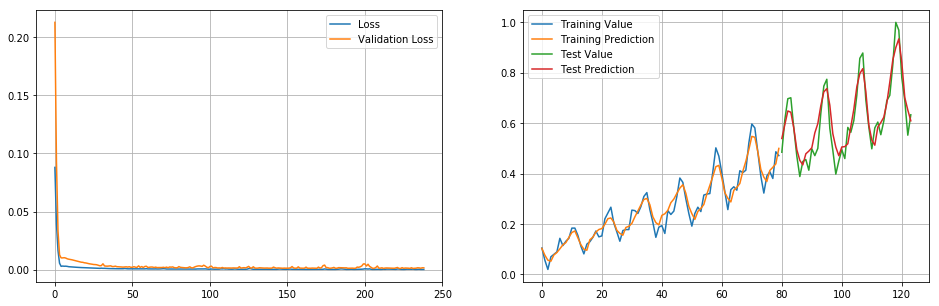

In [ ]:
plot_model_results(model, history)

## Using Recurrent Neural Network (RNN)

Recurrent neural networks can be used to account for the sequential/temporal dependencies between for the input data set.

In [ ]:
config = Config(batch_size=50, look_back=15, n_epochs=2000, train_portion=0.7, min_delta = 0.00001, rnn_nodes=15, stop_patience=200, lr_patience=100)

In [ ]:
# Creating sequential data set
trainX, trainY, testX, testY = time_data.create_sequential_data(look_back=config.look_back, train_portion=config.train_portion)

# Add channel dimension
trainX = trainX[:, :, np.newaxis]
testX = testX[:, :, np.newaxis]

### Simple RNN

Simple recurrent neural network

In [ ]:
# create and fit the RNN
model = Sequential(name='RnnSequential')

model.add(SimpleRNN(config.rnn_nodes, input_shape=(config.look_back, 1),name='SimpleRNN')) # the size of the output layer is always rrn_nodes no matter using LSTM or RNN or GRU

model.add(Dense(1, activation="linear", name='Output'))

model.compile(loss='mse', optimizer=Nadam(learning_rate=0.001))

model.summary()

Model: "RnnSequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
SimpleRNN (SimpleRNN)        (None, 15)                255       
_________________________________________________________________
Output (Dense)               (None, 1)                 16        
Total params: 271
Trainable params: 271
Non-trainable params: 0
_________________________________________________________________


In [ ]:
history = model.fit(trainX, trainY, epochs=config.n_epochs, 
                    batch_size=config.batch_size, validation_data=(testX, testY), callbacks=[config.early_stop_clbk, config.lr_plan])

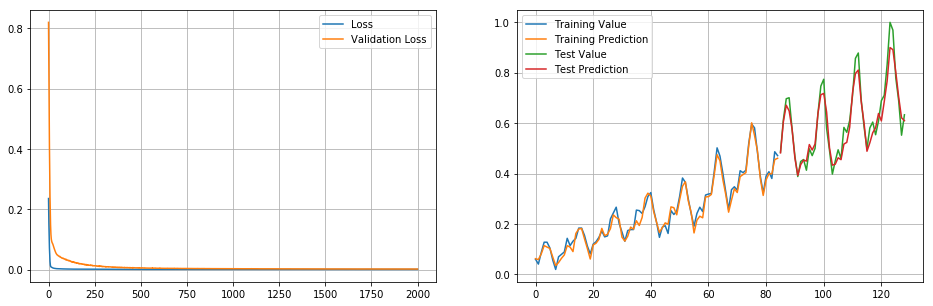

In [ ]:
plot_model_results(model, history)

### LSTM

Using Long Short Term Memory recurrent neural networks

In [ ]:
config.look_back = 5
# Creating sequential data set
trainX, trainY, testX, testY = time_data.create_sequential_data(look_back=config.look_back, train_portion=config.train_portion)

# Add channel dimension
trainX = trainX[:, :, np.newaxis]
testX = testX[:, :, np.newaxis]

In [ ]:
# create and fit the RNN
model = Sequential(name='RnnSequential')

model.add(LSTM(config.rnn_nodes, input_shape=(config.look_back, 1),name='LSTM')) # the size of the output layer is always rrn_nodes no matter using LSTM or RNN or GRU

model.add(Dense(1, activation="linear", name='Output'))

model.compile(loss='mse', optimizer=Nadam(learning_rate=0.001))

model.summary()

Model: "RnnSequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
LSTM (LSTM)                  (None, 15)                1020      
_________________________________________________________________
Output (Dense)               (None, 1)                 16        
Total params: 1,036
Trainable params: 1,036
Non-trainable params: 0
_________________________________________________________________


In [ ]:
history = model.fit(trainX, trainY, epochs=config.n_epochs, 
                    batch_size=config.batch_size, validation_data=(testX, testY), callbacks=[config.early_stop_clbk, config.lr_plan])

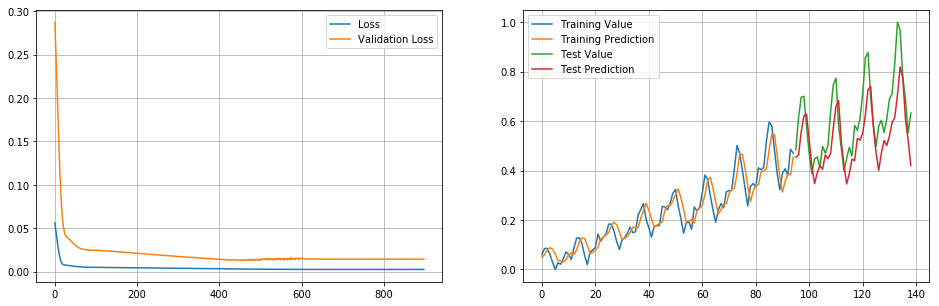

In [ ]:
plot_model_results(model, history)

### GRU

Using gated recurrent neural networks

In [ ]:
config.look_back = 5
# Creating sequential data set
trainX, trainY, testX, testY = time_data.create_sequential_data(look_back=config.look_back, train_portion=config.train_portion)

# Add channel dimension
trainX = trainX[:, :, np.newaxis]
testX = testX[:, :, np.newaxis]

In [ ]:
# create and fit the RNN
model = Sequential(name='RnnSequential')

model.add(GRU(config.rnn_nodes, input_shape=(config.look_back, 1),name='GRU')) # the size of the output layer is always rrn_nodes no matter using LSTM or RNN or GRU

model.add(Dense(1, activation="linear", name='Output'))

model.compile(loss='mse', optimizer=Nadam(learning_rate=0.001))

model.summary()

Model: "RnnSequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
GRU (GRU)                    (None, 15)                810       
_________________________________________________________________
Output (Dense)               (None, 1)                 16        
Total params: 826
Trainable params: 826
Non-trainable params: 0
_________________________________________________________________


In [ ]:
history = model.fit(trainX, trainY, epochs=config.n_epochs, 
                    batch_size=config.batch_size, validation_data=(testX, testY), callbacks=[config.early_stop_clbk, config.lr_plan])

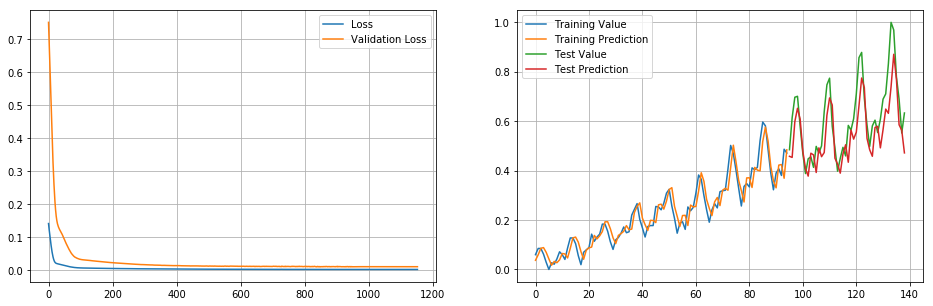

In [ ]:
plot_model_results(model, history)